In [1]:
%reset -f

In [2]:
import os
import warnings
import pickle as pkl
from joblib import dump, load
from time import time

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.linear_model import LogisticRegression,Lasso
from sklearn.svm import LinearSVC
from sklearn.naive_bayes import MultinomialNB,GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from sklearn.metrics import *
from sklearn.model_selection import (KFold, ParameterGrid, RandomizedSearchCV,
                                     cross_val_score, train_test_split)
from sklearn.preprocessing import Imputer, StandardScaler
from xgboost import XGBClassifier

%matplotlib inline
warnings.filterwarnings('ignore')
pd.options.display.float_format = '{:,.2f}'.format

In [ ]:
cwd = os.getcwd()

In [3]:
data_path = cwd + "../data/raw/"
models_path = cwd + "../models/"
results_path = cwd + "../results/"

In [5]:
os.chdir(data_path)

In [6]:
na_vals = ["", "?", "-", "None", "NA"]
train_vals = pd.read_csv("TrainingSetValues.csv", sep=",", na_values=na_vals)
train_labels = pd.read_csv("TrainingSetLabels.csv", sep=",", na_values=na_vals)

test = pd.read_csv("TestSetValues.csv", sep=",", na_values=na_vals)

In [7]:
test_id = test['id']

In [8]:
train_vals.head(3)

,id,amount_tsh,date_recorded,funder,gps_height,installer,longitude,latitude,wpt_name,num_private,...,payment_type,water_quality,quality_group,quantity,quantity_group,source,source_type,source_class,waterpoint_type,waterpoint_type_group
0,69572,"6,000.00",2011-03-14,Roman,1390,Roman,34.94,-9.86,none,0,...,annually,soft,good,enough,enough,spring,spring,groundwater,communal standpipe,communal standpipe
1,8776,0.00,2013-03-06,Grumeti,1399,GRUMETI,34.70,-2.15,Zahanati,0,...,never pay,soft,good,insufficient,insufficient,rainwater harvesting,rainwater harvesting,surface,communal standpipe,communal standpipe
2,34310,25.00,2013-02-25,Lottery Club,686,World vision,37.46,-3.82,Kwa Mahundi,0,...,per bucket,soft,good,enough,enough,dam,dam,surface,communal standpipe multiple,communal standpipe


In [9]:
train_labels.head(3)

,id,status_group
0,69572,functional
1,8776,functional
2,34310,functional


In [10]:
test.head(3)

,id,amount_tsh,date_recorded,funder,gps_height,installer,longitude,latitude,wpt_name,num_private,...,payment_type,water_quality,quality_group,quantity,quantity_group,source,source_type,source_class,waterpoint_type,waterpoint_type_group
0,50785,0.00,2013-02-04,Dmdd,1996,DMDD,35.29,-4.06,Dinamu Secondary School,0,...,never pay,soft,good,seasonal,seasonal,rainwater harvesting,rainwater harvesting,surface,other,other
1,51630,0.00,2013-02-04,Government Of Tanzania,1569,DWE,36.66,-3.31,Kimnyak,0,...,never pay,soft,good,insufficient,insufficient,spring,spring,groundwater,communal standpipe,communal standpipe
2,17168,0.00,2013-02-01,NaN,1567,NaN,34.77,-5.00,Puma Secondary,0,...,never pay,soft,good,insufficient,insufficient,rainwater harvesting,rainwater harvesting,surface,other,other


In [11]:
train_vals.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 59400 entries, 0 to 59399
Data columns (total 40 columns):
id                       59400 non-null int64
amount_tsh               59400 non-null float64
date_recorded            59400 non-null object
funder                   55763 non-null object
gps_height               59400 non-null int64
installer                55742 non-null object
longitude                59400 non-null float64
latitude                 59400 non-null float64
wpt_name                 59398 non-null object
num_private              59400 non-null int64
basin                    59400 non-null object
subvillage               59029 non-null object
region                   59400 non-null object
region_code              59400 non-null int64
district_code            59400 non-null int64
lga                      59400 non-null object
ward                     59400 non-null object
population               59400 non-null int64
public_meeting           56066 non-null object
r

In [12]:
train_labels.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 59400 entries, 0 to 59399
Data columns (total 2 columns):
id              59400 non-null int64
status_group    59400 non-null object
dtypes: int64(1), object(1)
memory usage: 928.2+ KB


In [13]:
train = pd.merge(train_vals,train_labels,left_on="id",right_on="id")

In [14]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 59400 entries, 0 to 59399
Data columns (total 41 columns):
id                       59400 non-null int64
amount_tsh               59400 non-null float64
date_recorded            59400 non-null object
funder                   55763 non-null object
gps_height               59400 non-null int64
installer                55742 non-null object
longitude                59400 non-null float64
latitude                 59400 non-null float64
wpt_name                 59398 non-null object
num_private              59400 non-null int64
basin                    59400 non-null object
subvillage               59029 non-null object
region                   59400 non-null object
region_code              59400 non-null int64
district_code            59400 non-null int64
lga                      59400 non-null object
ward                     59400 non-null object
population               59400 non-null int64
public_meeting           56066 non-null object
r

In [15]:
del train_labels
del train_vals

In [16]:
train.drop('id',axis=1,inplace=True)

In [17]:
def dropCols(data,cols,inplace_param = True):
    existing_cols = data.columns.intersection(cols)
    return data.drop(existing_cols,axis=1,inplace= inplace_param)

In [18]:
dropCols(train,['id'])
dropCols(test,['id'])

In [19]:
train.columns

Index(['amount_tsh', 'date_recorded', 'funder', 'gps_height', 'installer',
       'longitude', 'latitude', 'wpt_name', 'num_private', 'basin',
       'subvillage', 'region', 'region_code', 'district_code', 'lga', 'ward',
       'population', 'public_meeting', 'recorded_by', 'scheme_management',
       'scheme_name', 'permit', 'construction_year', 'extraction_type',
       'extraction_type_group', 'extraction_type_class', 'management',
       'management_group', 'payment', 'payment_type', 'water_quality',
       'quality_group', 'quantity', 'quantity_group', 'source', 'source_type',
       'source_class', 'waterpoint_type', 'waterpoint_type_group',
       'status_group'],
      dtype='object')

In [20]:
cat_var = train.dtypes[train.dtypes == 'object'].index
cat_var = cat_var.union(['district_code','region_code','construction_year'])
print("Categorical variables: %d"%len(cat_var),"\n",cat_var)

Categorical variables: 34 
 Index(['basin', 'construction_year', 'date_recorded', 'district_code',
       'extraction_type', 'extraction_type_class', 'extraction_type_group',
       'funder', 'installer', 'lga', 'management', 'management_group',
       'payment', 'payment_type', 'permit', 'public_meeting', 'quality_group',
       'quantity', 'quantity_group', 'recorded_by', 'region', 'region_code',
       'scheme_management', 'scheme_name', 'source', 'source_class',
       'source_type', 'status_group', 'subvillage', 'ward', 'water_quality',
       'waterpoint_type', 'waterpoint_type_group', 'wpt_name'],
      dtype='object')


In [21]:
num_var = train.columns.difference(cat_var)
print("Numerical variables:%d"%len(num_var),"\n",num_var)

Numerical variables:6 
 Index(['amount_tsh', 'gps_height', 'latitude', 'longitude', 'num_private',
       'population'],
      dtype='object')


In [22]:
train[cat_var] = train[cat_var].apply(lambda x: x.astype('category'))
train.dtypes

amount_tsh                float64
date_recorded            category
funder                   category
gps_height                  int64
installer                category
longitude                 float64
latitude                  float64
wpt_name                 category
num_private                 int64
basin                    category
subvillage               category
region                   category
region_code              category
district_code            category
lga                      category
ward                     category
population                  int64
public_meeting           category
recorded_by              category
scheme_management        category
scheme_name              category
permit                   category
construction_year        category
extraction_type          category
extraction_type_group    category
extraction_type_class    category
management               category
management_group         category
payment                  category
payment_type  

In [23]:
#water_quality can be ordinal
#construction_year, date_recorded datetime type

### Exploratory Data Analysis

In [24]:
#train_bkp = train.copy(deep=True)
#test_bkp = test.copy(deep=True)

In [25]:
train.describe(include='category').T.sort_values(by='unique',ascending=False)

,count,unique,top,freq
wpt_name,59398,37399,none,3563
subvillage,59029,19287,Madukani,508
scheme_name,30590,2695,K,682
installer,55742,2144,DWE,17402
ward,59400,2092,Igosi,307
funder,55763,1896,Government Of Tanzania,9084
date_recorded,59400,356,2011-03-15,572
lga,59400,125,Njombe,2503
construction_year,59400,55,0,20709
region_code,59400,27,11,5300


In [26]:
np.unique(train[['extraction_type','extraction_type_group']].values)

array(['afridev', 'cemo', 'climax', 'gravity', 'india mark ii',
       'india mark iii', 'ksb', 'mono', 'nira/tanira', 'other',
       'other - mkulima/shinyanga', 'other - play pump',
       'other - rope pump', 'other - swn 81', 'other handpump',
       'other motorpump', 'rope pump', 'submersible', 'swn 80', 'walimi',
       'wind-powered', 'windmill'], dtype=object)

In [27]:
pd.unique(train[['extraction_type','extraction_type_group']].values.ravel())

array(['gravity', 'submersible', 'swn 80', 'nira/tanira', 'india mark ii',
       'other', 'ksb', 'mono', 'windmill', 'wind-powered', 'afridev',
       'other - rope pump', 'rope pump', 'india mark iii',
       'other - swn 81', 'other handpump', 'other - play pump', 'cemo',
       'other motorpump', 'climax', 'walimi', 'other - mkulima/shinyanga'],
      dtype=object)

In [28]:
train.columns

Index(['amount_tsh', 'date_recorded', 'funder', 'gps_height', 'installer',
       'longitude', 'latitude', 'wpt_name', 'num_private', 'basin',
       'subvillage', 'region', 'region_code', 'district_code', 'lga', 'ward',
       'population', 'public_meeting', 'recorded_by', 'scheme_management',
       'scheme_name', 'permit', 'construction_year', 'extraction_type',
       'extraction_type_group', 'extraction_type_class', 'management',
       'management_group', 'payment', 'payment_type', 'water_quality',
       'quality_group', 'quantity', 'quantity_group', 'source', 'source_type',
       'source_class', 'waterpoint_type', 'waterpoint_type_group',
       'status_group'],
      dtype='object')

In [29]:
train.groupby(["status_group"]).mean()

,amount_tsh,gps_height,longitude,latitude,num_private,population
status_group,,,,,,
functional,461.80,740.13,34.24,-5.70,0.54,187.55
functional needs repair,267.07,627.61,31.24,-5.16,0.31,175.10
non functional,123.48,574.46,34.38,-5.81,0.41,170.02


In [30]:
train.groupby(["status_group"]).agg(['min','max','mean','count'])

amount_tsh                          gps_height        \
                               min        max   mean  count        min   max   
status_group                                                                   
functional                    0.00 350,000.00 461.80  32259        -90  2628   
functional needs repair       0.00 100,000.00 267.07   4317        -51  2770   
non functional                0.00 117,000.00 123.48  22824        -59  2627   

                                      longitude        ...   latitude         \
                          mean  count       min   max  ...       mean  count   
status_group                                           ...                     
functional              740.13  32259      0.00 40.35  ...      -5.70  32259   
functional needs repair 627.61   4317      0.00 40.28  ...      -5.16   4317   
non functional          574.46  22824      0.00 40.34  ...      -5.81  22824   

                        num_private                   population         \
                                min   max mean  count        min    max   
status_group                                                              
functional                        0  1402 0.54  32259          0  30500   
functional needs repair           0   160 0.31   4317          0  15300   
non functional                    0  1776 0.41  22824          0   9865   

                                       
                          mean  count  
status_group                           
functional              187.55  32259  
functional needs repair 175.10   4317  
non functional          170.02  22824  

[3 rows x 24 columns]

In [31]:
#same as above. kept just for reference of syntax
#train.groupby(["status_group"])['amount_tsh','gps_height','num_private','population'].agg(['min','max','mean','count'])

In [32]:
pd.pivot_table(data=train,index='status_group',columns=['source'],values=['amount_tsh'])

amount_tsh                                    \
source                         dam hand dtw   lake machine dbh other   
status_group                                                           
functional                  303.98   416.34 115.31      447.16 68.57   
functional needs repair      58.54 1,152.94   4.17      621.75 20.00   
non functional                5.37   257.89 161.79      138.05 40.82   

                                                                           \
source                  rainwater harvesting    river shallow well spring   
status_group                                                                
functional                             12.30 1,028.40       128.15 514.75   
functional needs repair                 6.37   412.20        70.72 197.58   
non functional                         10.35   248.73        50.28 154.90   

                                 
source                  unknown  
status_group                     
functional               164.38  
functional needs repair  375.00  
non functional            12.33

#### dams,river,shallowwell,spring which have more water are functional 
#### handdtw,machinedbh,unknown source have more water but most of them need to be repaired
#### lakes have more water but are not functional 

In [33]:
pd.pivot_table(data=train,index='status_group',columns=['source'],values=['population'],aggfunc=np.sum)

population                                      \
source                         dam hand dtw    lake machine dbh  other   
status_group                                                             
functional                  107143    49773   35058     1604910  17018   
functional needs repair      11349     4489    7101      134342    150   
non functional               56926    49861  161315     1063524   9713   

                                                                             \
source                  rainwater harvesting    river shallow well   spring   
status_group                                                                  
functional                            290376  1120729      1493024  1325069   
functional needs repair                47749   270680       111790   167576   
non functional                        147909   563374      1369448   442678   

                                 
source                  unknown  
status_group                     
functional                 7182  
functional needs repair     690  
non functional            15707

#### dams,machine dbh,rainwater harvesting, river,shallow well,spring which have more population are functional 
#### lake,unknown sources which  have more population are non-functional

### Preprocessing

In [34]:
rand_num = 3423

In [35]:
target_var = 'status_group'
y = train[target_var]
X = train.drop(target_var, axis=1)

In [36]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=rand_num)

In [37]:
del train
del X
del y

In [38]:
print(X_train.shape)
print(X_test.shape)

(41580, 39)
(17820, 39)


In [39]:
cols_to_drop = ['longitude','latitude','recorded_by','scheme_name','ward',
                'subvillage','wpt_name','date_recorded','funder','installer',
                'lga','construction_year','region_code','district_code',
               'management','scheme_management','extraction_type',
                'extraction_type_group','region',
               'quantity_group','source_type','source_class','payment_type',
               'quantity_group','waterpoint_type','water_quality']

dropCols(X_train,cols_to_drop)
dropCols(X_test,cols_to_drop)
dropCols(test,cols_to_drop)

In [40]:
print(X_train.describe().T)
print(X_train.describe(include=['category']).T)

                count   mean      std    min  25%    50%      75%        max
amount_tsh  41,580.00 305.92 2,641.65   0.00 0.00   0.00    20.00 350,000.00
gps_height  41,580.00 670.28   693.51 -63.00 0.00 374.00 1,320.00   2,770.00
num_private 41,580.00   0.54    14.26   0.00 0.00   0.00     0.00   1,776.00
population  41,580.00 179.81   483.43   0.00 0.00  25.00   210.00  30,500.00
                       count unique                 top   freq
basin                  41580      9       Lake Victoria   7177
public_meeting         39255      2                True  35755
permit                 39399      2                True  27182
extraction_type_class  41580      7             gravity  18719
management_group       41580      5          user-group  36751
payment                41580      7           never pay  17766
quality_group          41580      6                good  35551
quantity               41580      5              enough  23239
source                 41580     10             

In [41]:
X_train['source'].dtype

CategoricalDtype(categories=['dam', 'hand dtw', 'lake', 'machine dbh', 'other',
                  'rainwater harvesting', 'river', 'shallow well', 'spring',
                  'unknown'],
                 ordered=False)

In [42]:
X_train['source'] = X_train['source'].str.replace('unknown','other')
X_test['source'] = X_test['source'].str.replace('unknown','other')
test['source'] = test['source'].str.replace('unknown','other')
print(X_train.source.unique())


['spring' 'shallow well' 'river' 'machine dbh' 'rainwater harvesting'
 'lake' 'other' 'hand dtw' 'dam']


In [43]:
X_train['management_group'] = X_train['management_group'].str.replace('unknown','other')
X_test['management_group'] = X_test['management_group'].str.replace('unknown','other')
test['management_group'] = test['management_group'].str.replace('unknown','other')
print(X_train.management_group.unique())

['user-group' 'commercial' 'other' 'parastatal']


In [44]:
X_train['payment'] = X_train['payment'].str.replace('unknown','other')
X_test['payment'] = X_test['payment'].str.replace('unknown','other')
test['payment'] = test['payment'].str.replace('unknown','other')
print(X_train.payment.unique())

['never pay' 'pay per bucket' 'pay when scheme fails' 'other'
 'pay monthly' 'pay annually']


In [45]:
new_cat_var = X_train.dtypes[X_train.dtypes == 'object'].index
print(new_cat_var)
print(X_train.info())

Index(['management_group', 'payment', 'source'], dtype='object')
<class 'pandas.core.frame.DataFrame'>
Int64Index: 41580 entries, 52775 to 30287
Data columns (total 14 columns):
amount_tsh               41580 non-null float64
gps_height               41580 non-null int64
num_private              41580 non-null int64
basin                    41580 non-null category
population               41580 non-null int64
public_meeting           39255 non-null category
permit                   39399 non-null category
extraction_type_class    41580 non-null category
management_group         41580 non-null object
payment                  41580 non-null object
quality_group            41580 non-null category
quantity                 41580 non-null category
source                   41580 non-null object
waterpoint_type_group    41580 non-null category
dtypes: category(7), float64(1), int64(3), object(3)
memory usage: 2.8+ MB
None


In [46]:
X_train[new_cat_var] = X_train[new_cat_var].apply(lambda x: x.astype('category'))
X_test[new_cat_var] = X_test[new_cat_var].apply(lambda x: x.astype('category'))
test[new_cat_var] = test[new_cat_var].apply(lambda x: x.astype('category'))

#### Imputation

In [47]:
X_train[['public_meeting','permit']].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 41580 entries, 52775 to 30287
Data columns (total 2 columns):
public_meeting    39255 non-null category
permit            39399 non-null category
dtypes: category(2)
memory usage: 406.2 KB


In [48]:
X_train['public_meeting'].fillna(X_train['public_meeting'].value_counts().index[0],inplace=True)
X_test['public_meeting'].fillna(X_test['public_meeting'].value_counts().index[0],inplace=True)
test['public_meeting'].fillna(test['public_meeting'].value_counts().index[0],inplace=True)

In [49]:
X_train['permit'].fillna(X_train['permit'].value_counts().index[0],inplace=True)
X_test['permit'].fillna(X_test['permit'].value_counts().index[0],inplace=True)
test['permit'].fillna(test['permit'].value_counts().index[0],inplace=True)
print(X_train.isna().sum())

amount_tsh               0
gps_height               0
num_private              0
basin                    0
population               0
public_meeting           0
permit                   0
extraction_type_class    0
management_group         0
payment                  0
quality_group            0
quantity                 0
source                   0
waterpoint_type_group    0
dtype: int64


#### Standardize the numerical variables

In [50]:
new_num_var = X_train.dtypes[X_train.dtypes != 'category'].index
new_cat_var = X_train.dtypes[X_train.dtypes == 'category'].index

In [51]:
print(X_train[new_num_var].info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 41580 entries, 52775 to 30287
Data columns (total 4 columns):
amount_tsh     41580 non-null float64
gps_height     41580 non-null int64
num_private    41580 non-null int64
population     41580 non-null int64
dtypes: float64(1), int64(3)
memory usage: 1.6 MB
None


In [52]:
scaler = StandardScaler()
X_train[new_num_var] = scaler.fit_transform(X_train[new_num_var])
X_test[new_num_var] = scaler.transform(X_test[new_num_var])
test[new_num_var] = scaler.transform(test[new_num_var])
print(X_train[new_num_var].describe())

       amount_tsh  gps_height  num_private  population
count   41,580.00   41,580.00    41,580.00   41,580.00
mean        -0.00        0.00         0.00        0.00
std          1.00        1.00         1.00        1.00
min         -0.12       -1.06        -0.04       -0.37
25%         -0.12       -0.97        -0.04       -0.37
50%         -0.12       -0.43        -0.04       -0.32
75%         -0.11        0.94        -0.04        0.06
max        132.38        3.03       124.53       62.72


#### Dummy code Categorical variables

In [53]:
#X_train = pd.get_dummies(X_train,drop_first=True,prefix='d',prefix_sep='_')
X_train = pd.get_dummies(X_train,drop_first=True)
X_test = pd.get_dummies(X_test,drop_first=True)
test = pd.get_dummies(test,drop_first=True)

In [54]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 41580 entries, 52775 to 30287
Data columns (total 50 columns):
amount_tsh                                  41580 non-null float64
gps_height                                  41580 non-null float64
num_private                                 41580 non-null float64
population                                  41580 non-null float64
basin_Lake Nyasa                            41580 non-null uint8
basin_Lake Rukwa                            41580 non-null uint8
basin_Lake Tanganyika                       41580 non-null uint8
basin_Lake Victoria                         41580 non-null uint8
basin_Pangani                               41580 non-null uint8
basin_Rufiji                                41580 non-null uint8
basin_Ruvuma / Southern Coast               41580 non-null uint8
basin_Wami / Ruvu                           41580 non-null uint8
public_meeting_True                         41580 non-null uint8
permit_True                       

#### Build Models

In [55]:
metric = 'accuracy'
models = []
model_names = []
scores = []
train_preds = None
val_preds = None

In [56]:
#main method to fit a model,do predictions and print metrics
def predictModelMetrics(model,model_name):
    train_preds,val_preds = resetVar()
    train_preds,val_preds = doPredict(model,model_name)
    printMetrics(model,train_preds,val_preds)

#reset prediction variables before running next model
def resetVar():
    train_preds = None
    val_preds = None
    return train_preds,val_preds

#make predictions
def doPredict(model,model_name):
    model.fit(X_train,y_train)
    train_preds = model.predict(X_train)
    val_preds = model.predict(X_test)
    models.append(model_name)
    return train_preds,val_preds

#prints and captures metrics
def printMetrics(model,train_preds,val_preds):
    print("Train Accuracy: %.2f"%accuracy_score(y_train,train_preds))
    
    #k-fold with k=5
    val_scores = cross_val_score(model,X_test,y_test, cv=5, scoring=metric)
    cv_score = val_scores.mean()
    print("Cross Validation Accuracy: %.2f" %cv_score)
    
    print("-------------------------------------")
    print("Confusion Matrix:")
    print(pd.crosstab(y_test,val_preds,rownames=['Actual'],colnames=['Predicted'],margins=True))
    #print(classification_report(y_val,val_preds))
    scores.append(round(cv_score,2))
    
    #print summary of model accuracies
def summarizeResults():
    results = pd.DataFrame({"Model":models, "Score":scores})
    print(results)
    
def loadModel(model_name):
    try:
        model = load(models_path + model_name + ".joblib")
        return model
    except:
        return None
    
def saveModel(model,model_name):
    dump(model,models_path + modelName + ".joblib")

In [57]:
modelName = "LogisticRegression"
lr = LogisticRegression(multi_class='ovr')
predictModelMetrics(lr,modelName)

Train Accuracy: 0.72
Cross Validation Accuracy: 0.72
-------------------------------------
Confusion Matrix:
Predicted                functional  functional needs repair  non functional  \
Actual                                                                         
functional                     8893                        5             767   
functional needs repair        1096                        0             212   
non functional                 2880                        0            3967   
All                           12869                        5            4946   

Predicted                  All  
Actual                          
functional                9665  
functional needs repair   1308  
non functional            6847  
All                      17820  


In [58]:
modelName = "LinearSVC"
svc = LinearSVC(C=0.01)
predictModelMetrics(svc,modelName)

Train Accuracy: 0.72
Cross Validation Accuracy: 0.72
-------------------------------------
Confusion Matrix:
Predicted                functional  non functional    All
Actual                                                    
functional                     8994             671   9665
functional needs repair        1121             187   1308
non functional                 3017            3830   6847
All                           13132            4688  17820


In [59]:
acc_scores = []
rng = range(2,20)
for i in rng:
    knn = KNeighborsClassifier(i)
    knn.fit(X_train,y_train)
    t_preds = knn.predict(X_train)
    acc_scores.append(accuracy_score(y_train,t_preds))

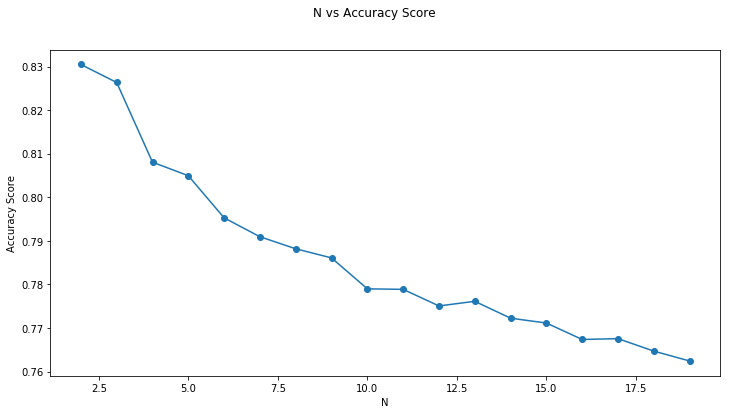

In [60]:
plt.figure(figsize=(12,6))
plt.plot(rng,acc_scores,marker="o")
plt.xlabel("N")
plt.ylabel("Accuracy Score")
plt.suptitle("N vs Accuracy Score")
plt.show()

In [61]:
modelName = "KNN5"
knn = KNeighborsClassifier(n_neighbors=2)
predictModelMetrics(knn,modelName)

Train Accuracy: 0.83
Cross Validation Accuracy: 0.71
-------------------------------------
Confusion Matrix:
Predicted                functional  functional needs repair  non functional  \
Actual                                                                         
functional                     8693                      322             650   
functional needs repair         894                      281             133   
non functional                 2444                      270            4133   
All                           12031                      873            4916   

Predicted                  All  
Actual                          
functional                9665  
functional needs repair   1308  
non functional            6847  
All                      17820  


In [62]:
modelName = "RandomForestClassifier"
rfc = loadModel(modelName)
if(rfc == None):
    rfc = RandomForestClassifier(n_estimators=500,max_depth=15,random_state=rand_num)
    predictModelMetrics(rfc,modelName)
    saveModel(rfc,modelName)

Train Accuracy: 0.81
Cross Validation Accuracy: 0.76
-------------------------------------
Confusion Matrix:
Predicted                functional  functional needs repair  non functional  \
Actual                                                                         
functional                     8992                       64             609   
functional needs repair         984                      151             173   
non functional                 2304                       33            4510   
All                           12280                      248            5292   

Predicted                  All  
Actual                          
functional                9665  
functional needs repair   1308  
non functional            6847  
All                      17820  


In [63]:
modelName = "XGBoost_Classifier"
xgbc = loadModel(modelName)
if(xgbc == None):
    xgbc = XGBClassifier(max_depth=10,learning_rate= 0.01,n_estimators= 300,random_state=rand_num)
    predictModelMetrics(xgbc,modelName)
    saveModel(xgbc,modelName)

Train Accuracy: 0.79
Cross Validation Accuracy: 0.75
-------------------------------------
Confusion Matrix:
Predicted                functional  functional needs repair  non functional  \
Actual                                                                         
functional                     9017                       90             558   
functional needs repair         954                      195             159   
non functional                 2411                       61            4375   
All                           12382                      346            5092   

Predicted                  All  
Actual                          
functional                9665  
functional needs repair   1308  
non functional            6847  
All                      17820  


In [64]:
test_preds = rfc.predict(test)

In [65]:
result = pd.DataFrame({'id':test_id,'status_group':test_preds})

In [66]:
result.to_csv(results_path + "Submission.csv",index=False)